# GHG HLM on Scope 3 source Business Travel

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import warnings
from statsmodels.regression.mixed_linear_model import MixedLM


#read in dataset GHG_post_outliers data set
business_travel=pd.read_csv('/Users/amberjensen/Desktop/GHG_Emissions_Project/business_travel.csv')

In [2]:
#check for info
business_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                6060 non-null   object 
 1   account_id                  6060 non-null   int64  
 2   Year                        6060 non-null   int64  
 3   incorporated_country        6060 non-null   object 
 4   Primary activity            6060 non-null   object 
 5   Primary sector              6060 non-null   object 
 6   Market_Cap_USD              5034 non-null   float64
 7   Third_party_verification    6054 non-null   object 
 8   Revenue_USD                 5075 non-null   float64
 9   ebitda_USD                  5075 non-null   float64
 10  grossProfit_USD             5075 non-null   float64
 11  netIncome_USD               5075 non-null   float64
 12  cashAndCashEquivalents_USD  5075 non-null   float64
 13  shortTermInvestments_USD    5075 

In [3]:
#show a df for business_travel
business_travel.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9.548124e+09,Third-party verification or assurance process ...,1.728470e+09,1.565910e+09,...,8.544560e+09,1.107567e+10,1.031240e+09,8.544560e+09,7.302500e+08,1.004443e+10,Business travel,2549.33,3.389500e+02,4072324
1,abrdn,17604,2018,United Kingdom,Insurance,Financial services,1.019344e+10,Third-party verification or assurance process ...,2.912110e+09,1.482090e+09,...,6.626860e+09,1.589659e+10,6.322060e+09,6.626860e+09,1.647190e+09,9.574530e+09,Business travel,15745.00,7.197250e+03,4072324
2,Antofagasta,820,2018,United Kingdom,Other non-ferrous ore mining,Metallic mineral mining,7.721230e+09,Third-party verification or assurance process ...,4.733100e+09,2.092800e+09,...,1.060800e+09,1.410250e+10,4.664400e+09,1.924000e+09,2.493900e+09,9.438100e+09,Business travel,5559.00,3.292186e+06,4072324
3,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,9.900000e+07,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,Business travel,33000.00,3.804718e+05,4072324
4,Arm Ltd.,950,2018,United Kingdom,Electronic components,Electrical & electronic equipment,NaN,No third-party verification or assurance,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Business travel,18001.70,7.728538e+03,4072324


In [4]:
#define a list of numeric columns
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_amount', 'scope_1_2_emissions_amount']

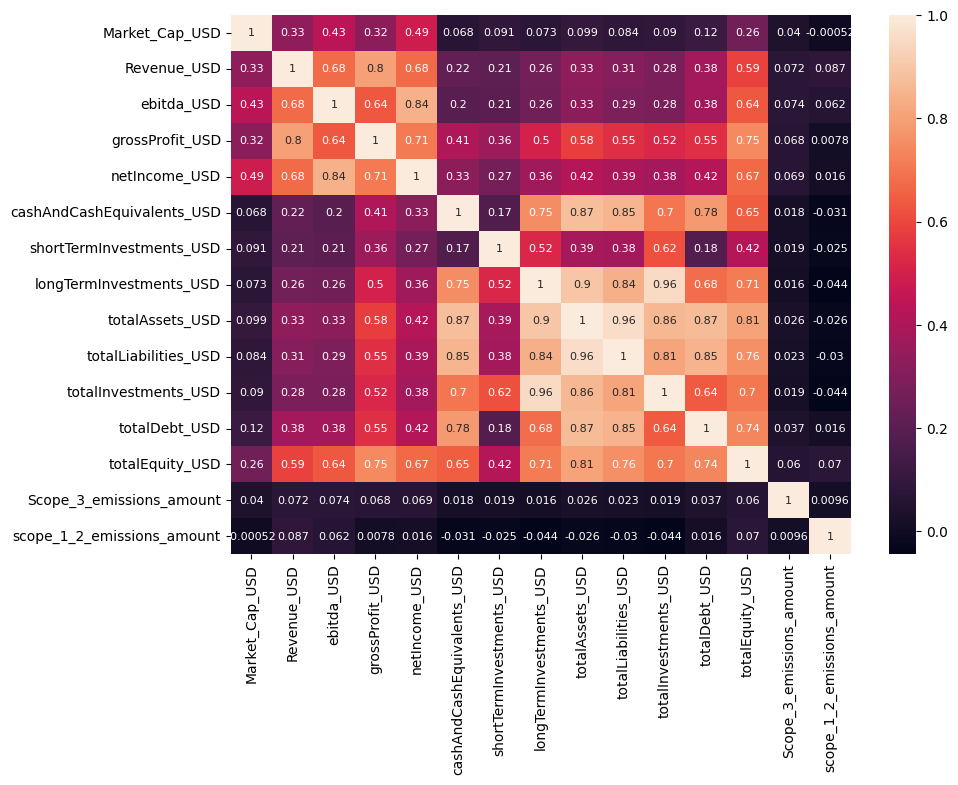

In [5]:
#plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(business_travel[numeric_cols].corr(), annot=True, annot_kws={"size": 8})
plt.show()

In [6]:
#correlation matrix
business_travel[numeric_cols].corr()

,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount
Market_Cap_USD,1.000000,0.332978,0.434058,0.320739,0.485907,0.068233,0.090872,0.072590,0.098819,0.083813,0.090201,0.117803,0.258924,0.040201,-0.000517
Revenue_USD,0.332978,1.000000,0.677184,0.796317,0.676501,0.220429,0.209446,0.264220,0.334922,0.308914,0.279610,0.380111,0.590152,0.072079,0.086991
ebitda_USD,0.434058,0.677184,1.000000,0.636743,0.843645,0.199743,0.207697,0.256725,0.325587,0.287194,0.280046,0.378435,0.636236,0.073807,0.061531
grossProfit_USD,0.320739,0.796317,0.636743,1.000000,0.710210,0.406550,0.360472,0.503256,0.578178,0.547068,0.519159,0.546120,0.745798,0.068480,0.007843
netIncome_USD,0.485907,0.676501,0.843645,0.710210,1.000000,0.325956,0.267046,0.364567,0.423504,0.393906,0.375982,0.420039,0.673077,0.069432,0.015864
cashAndCashEquivalents_USD,0.068233,0.220429,0.199743,0.406550,0.325956,1.000000,0.173305,0.754177,0.874107,0.849320,0.699336,0.783165,0.645215,0.018327,-0.030801
shortTermInvestments_USD,0.090872,0.209446,0.207697,0.360472,0.267046,0.173305,1.000000,0.520527,0.387100,0.382433,0.617374,0.180996,0.421290,0.018502,-0.024633
longTermInvestments_USD,0.072590,0.264220,0.256725,0.503256,0.364567,0.754177,0.520527,1.000000,0.895511,0.838376,0.955030,0.677829,0.712495,0.016128,-0.044396
totalAssets_USD,0.098819,0.334922,0.325587,0.578178,0.423504,0.874107,0.387100,0.895511,1.000000,0.960164,0.857267,0.865639,0.805682,0.026352,-0.025643
totalLiabilities_USD,0.083813,0.308914,0.287194,0.547068,0.393906,0.849320,0.382433,0.838376,0.960164,1.000000,0.808540,0.848562,0.758700,0.022644,-0.029562


In [7]:
#drop columns due to collinearity, keeping total
business_travel=business_travel.drop(columns=['cashAndCashEquivalents_USD','longTermInvestments_USD',"totalLiabilities_USD",
                                              "account_name", "Third_party_verification", "Scope_3_emissions_type"])

In [8]:
business_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  6060 non-null   int64  
 1   Year                        6060 non-null   int64  
 2   incorporated_country        6060 non-null   object 
 3   Primary activity            6060 non-null   object 
 4   Primary sector              6060 non-null   object 
 5   Market_Cap_USD              5034 non-null   float64
 6   Revenue_USD                 5075 non-null   float64
 7   ebitda_USD                  5075 non-null   float64
 8   grossProfit_USD             5075 non-null   float64
 9   netIncome_USD               5075 non-null   float64
 10  shortTermInvestments_USD    5075 non-null   float64
 11  totalAssets_USD             5075 non-null   float64
 12  totalInvestments_USD        5075 non-null   float64
 13  totalDebt_USD               5075 

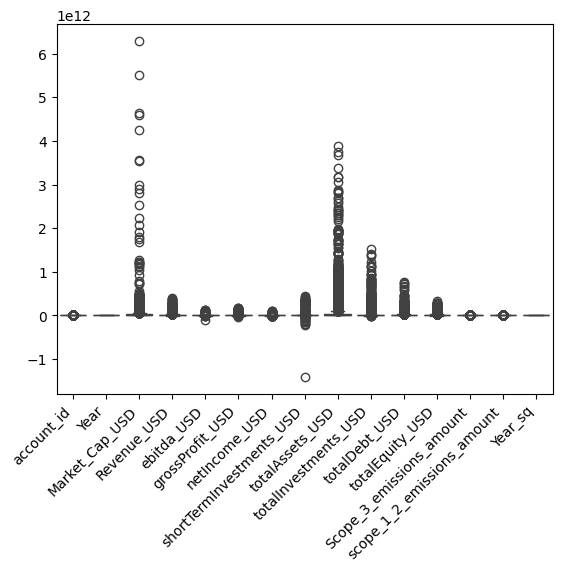

In [9]:
sns.boxplot(business_travel)
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# copy dataframe
business_travel_no_transform = business_travel.copy()
# Change 'incorporated_country' to 'Countries' in business_travel dataframe
business_travel_no_transform = business_travel_no_transform.rename(columns={'incorporated_country': 'Countries',
                                                       'Primary activity': 'Primary_activity',
                                                        'Primary sector': 'Primary_sector'})

print(business_travel_no_transform.info())
business_travel_no_transform.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  6060 non-null   int64  
 1   Year                        6060 non-null   int64  
 2   Countries                   6060 non-null   object 
 3   Primary_activity            6060 non-null   object 
 4   Primary_sector              6060 non-null   object 
 5   Market_Cap_USD              5034 non-null   float64
 6   Revenue_USD                 5075 non-null   float64
 7   ebitda_USD                  5075 non-null   float64
 8   grossProfit_USD             5075 non-null   float64
 9   netIncome_USD               5075 non-null   float64
 10  shortTermInvestments_USD    5075 non-null   float64
 11  totalAssets_USD             5075 non-null   float64
 12  totalInvestments_USD        5075 non-null   float64
 13  totalDebt_USD               5075 

,account_id,Year,Countries,Primary_activity,Primary_sector,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,netIncome_USD,shortTermInvestments_USD,totalAssets_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,44,2018,United Kingdom,Asset managers,Financial services,9.548124e+09,1.728470e+09,1.565910e+09,1.728470e+09,1.577340e+09,0.0,1.107567e+10,8.544560e+09,7.302500e+08,1.004443e+10,2549.33,3.389500e+02,4072324
1,17604,2018,United Kingdom,Insurance,Financial services,1.019344e+10,2.912110e+09,1.482090e+09,2.814320e+09,1.054100e+09,7620000.0,1.589659e+10,6.626860e+09,1.647190e+09,9.574530e+09,15745.00,7.197250e+03,4072324
2,820,2018,United Kingdom,Other non-ferrous ore mining,Metallic mineral mining,7.721230e+09,4.733100e+09,2.092800e+09,1.925400e+09,5.437000e+08,863200000.0,1.410250e+10,1.924000e+09,2.493900e+09,9.438100e+09,5559.00,3.292186e+06,4072324
3,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,1.443500e+10,2.260000e+09,2.729000e+09,1.067000e+09,72000000.0,1.248000e+10,1.710000e+08,4.344000e+09,3.670000e+09,33000.00,3.804718e+05,4072324
4,950,2018,United Kingdom,Electronic components,Electrical & electronic equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18001.70,7.728538e+03,4072324


In [11]:
business_travel_no_transform['Primary_sector'].value_counts()

Primary_sector
Financial services                                    1110
Electrical & electronic equipment                      631
Chemicals                                              415
Construction                                           270
Food & beverage processing                             252
Specialized professional services                      238
Media, telecommunications & data center services       220
Biotech & pharma                                       200
Discretionary retail                                   164
Powered machinery                                      157
Energy utility networks                                148
Convenience retail                                     132
Trading, wholesale, distribution, rental & leasing     128
Thermal power generation                               118
Medical equipment & supplies                           110
Other services                                          90
Bars, hotels & restaurants               

In [12]:
business_travel_no_transform['Primary_activity'].value_counts().head(20)

Primary_activity
Banks                                                 585
Insurance                                             287
Electronic components                                 245
Telecommunications services                           202
Other professional services                           202
Pharmaceuticals                                       158
REIT                                                  142
Supermarkets, food & drugstores                       132
Electricity networks                                  130
Specialty chemicals                                   128
Other base chemicals                                  120
Electrical equipment                                  118
Personal care & household products                     99
CCGT generation                                        98
Asset managers                                         96
Communications equipment                               94
Non-residential building construction                  

In [13]:
# Looking at missing data
print(business_travel_no_transform.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                16.9
netIncome_USD                 16.3
totalInvestments_USD          16.3
totalEquity_USD               16.3
Revenue_USD                   16.3
ebitda_USD                    16.3
grossProfit_USD               16.3
totalDebt_USD                 16.3
shortTermInvestments_USD      16.3
totalAssets_USD               16.3
scope_1_2_emissions_amount     0.3
Scope_3_emissions_amount       0.0
account_id                     0.0
Year                           0.0
Primary_sector                 0.0
Primary_activity               0.0
Countries                      0.0
Year_sq                        0.0
dtype: float64


Apply signed log transformation and split data by company and year into train_df (2018-2022) and test_df (2023):

In [14]:
numeric_cols = [
    'Market_Cap_USD', 'totalInvestments_USD', 'Revenue_USD', 'ebitda_USD', 'grossProfit_USD',
    'netIncome_USD', 'totalDebt_USD', 'shortTermInvestments_USD', 'totalAssets_USD',
    'totalEquity_USD', 'scope_1_2_emissions_amount', 'Scope_3_emissions_amount'
]
required_cols = [
    'account_id', 'Year', 'Year_sq', 'Countries', 'Primary_activity', 'Primary_sector'
] + numeric_cols

# --- Prepare Data ---
df = business_travel_no_transform[required_cols].dropna()

# --- Signed log transform ---
def signed_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

for col in numeric_cols:
    df[f'slog_{col}'] = signed_log(df[col])

# --- Company-level split by year ---
train_df = df[df['Year'].between(2018, 2022)].copy()
test_df  = df[df['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (4130, 30)
Test shape: (789, 30)


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4130 entries, 0 to 5017
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       4130 non-null   int64  
 1   Year                             4130 non-null   int64  
 2   Year_sq                          4130 non-null   int64  
 3   Countries                        4130 non-null   object 
 4   Primary_activity                 4130 non-null   object 
 5   Primary_sector                   4130 non-null   object 
 6   Market_Cap_USD                   4130 non-null   float64
 7   totalInvestments_USD             4130 non-null   float64
 8   Revenue_USD                      4130 non-null   float64
 9   ebitda_USD                       4130 non-null   float64
 10  grossProfit_USD                  4130 non-null   float64
 11  netIncome_USD                    4130 non-null   float64
 12  totalDebt_USD            

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 5019 to 6057
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       789 non-null    int64  
 1   Year                             789 non-null    int64  
 2   Year_sq                          789 non-null    int64  
 3   Countries                        789 non-null    object 
 4   Primary_activity                 789 non-null    object 
 5   Primary_sector                   789 non-null    object 
 6   Market_Cap_USD                   789 non-null    float64
 7   totalInvestments_USD             789 non-null    float64
 8   Revenue_USD                      789 non-null    float64
 9   ebitda_USD                       789 non-null    float64
 10  grossProfit_USD                  789 non-null    float64
 11  netIncome_USD                    789 non-null    float64
 12  totalDebt_USD          

In [17]:
print((train_df == 0).sum().sum())
print((test_df == 0).sum().sum())

2122
548


## Business Travel Null Mixed-Effects Model

Null mixed-effects model (random intercept only) to predict log-transformed Scope 3 emissions. The model serves as a baseline, capturing only the average emission level for each company, without incorporating any explanatory variables, and quantifies the improvement gained by including additional features and structure. The model is trained on 2018–2022 data and evaluated on a test set from 2023.

Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies
- Fixed Effects:
    - Intercept only (no predictors)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 4130    Method:             REML                        
No. Groups:       874     Scale:              1.1147                      
Min. group size:  1       Log-Likelihood:     -7196.9540                  
Max. group size:  5       Converged:          Yes                         
Mean group size:  4.7                                                     
------------------------------------------------------------------------------
                Coef.     Std.Err.        z        P>|z|     [0.025     0.975]
------------------------------------------------------------------------------
Intercept       8.254        0.059     138.965     0.000      8.138      8.371
Group Var       2.830        0.157                                            

R²(log):    -0.34%
R²(orig):   -12.66%
MAPE:       560.15%
MAPE(log):  19.21%
MAE(log):   1.40
RMS

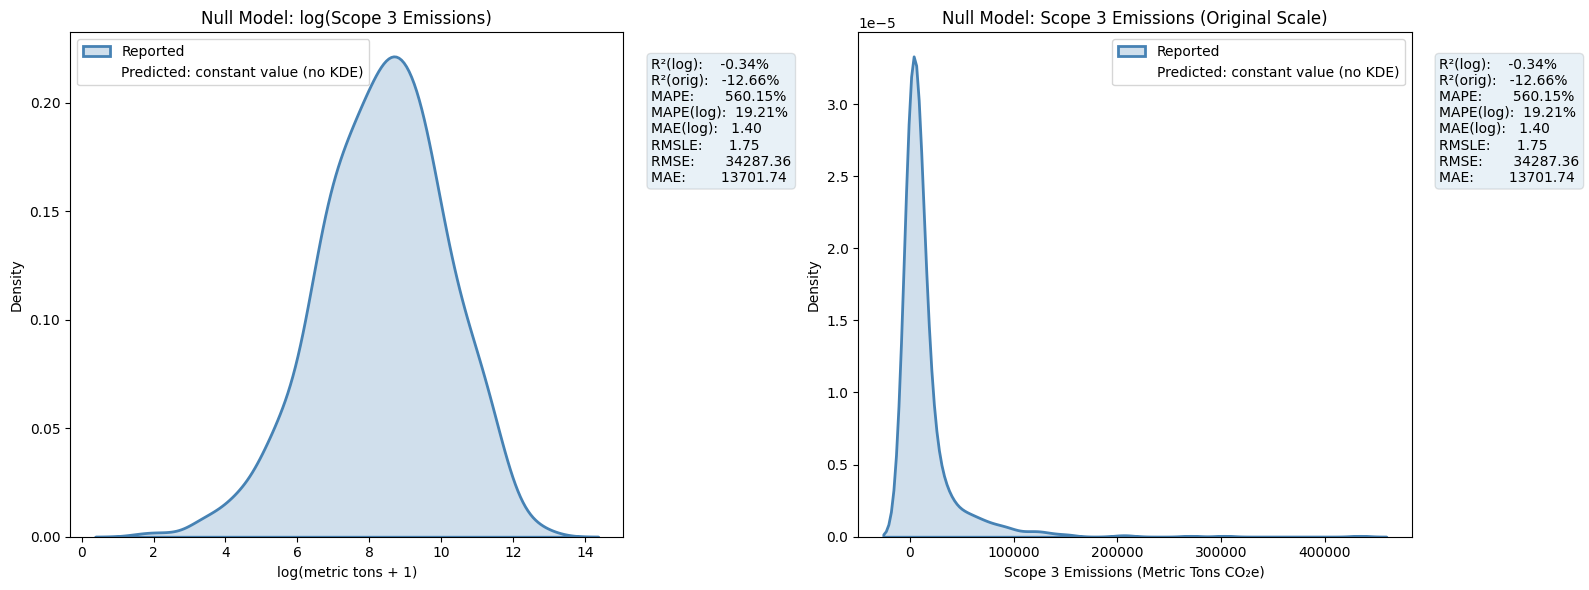

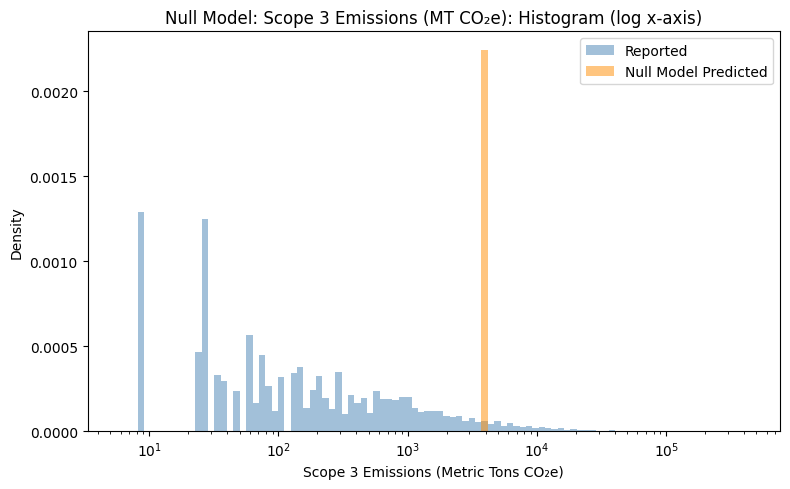

In [18]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE NULL MODEL (random intercept only) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    null_model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ 1",
        train_df,
        groups=train_df["account_id"]
    )
    null_result = null_model.fit(method="lbfgs")

if not null_result.converged:
    print("WARNING: Null model did not fully converge.")

print(null_result.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_null'] = null_result.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_null']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_null'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics text
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[0], color='gray')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Null Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[1], color='gray')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Null Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Null Model Predicted")
plt.xscale("log")
plt.title("Null Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
null_model_metrics = {
    "Model": "Null (RI)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "Random intercept only"
}

## Business Travel Two-Level Mixed-Effects Model

Two-level hierarchical linear mixed-effects model to predict log-transformed Scope 3 emissions at the company level. The model is fit to training data (from 2018–2022), and predictions are evaluated on a test set (from 2023).  This model provides a baseline for including time trends and company-level variability.
 
Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies.<br>
- Fixed Effects:
    - Year (numeric)
    - Year squared ('Year_sq', quadratic time trend)

Two-Level Model: Company/year group size summary:
count    874.000000
mean       4.725400
std        0.812345
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
dtype: float64
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 4130    Method:             REML                        
No. Groups:       874     Scale:              0.7441                      
Min. group size:  1       Log-Likelihood:     -6541.9277                  
Max. group size:  5       Converged:          No                          
Mean group size:  4.7                                                     
---------------------------------------------------------------------------
              Coef.      Std.Err.     z     P>|z|     [0.025       0.975]  
---------------------------------------------------------------------------
Intercept  -494992.165  33051.456  -14.97

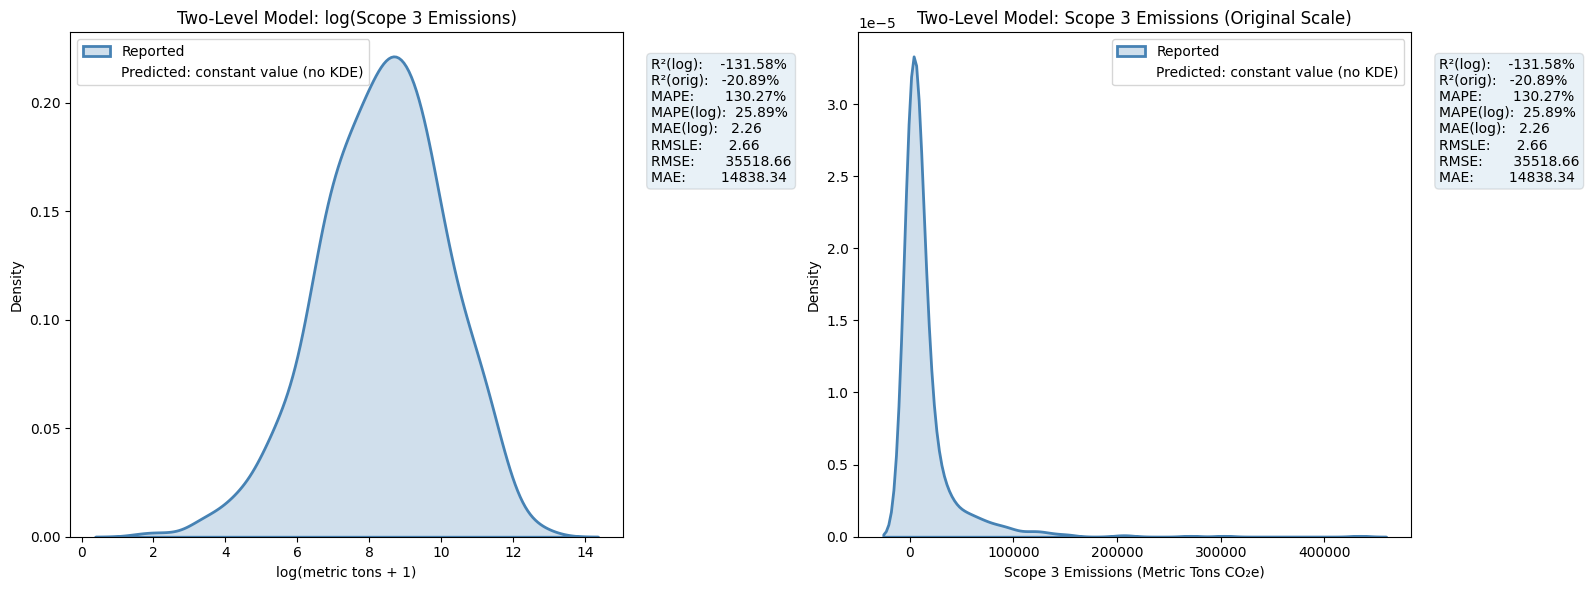

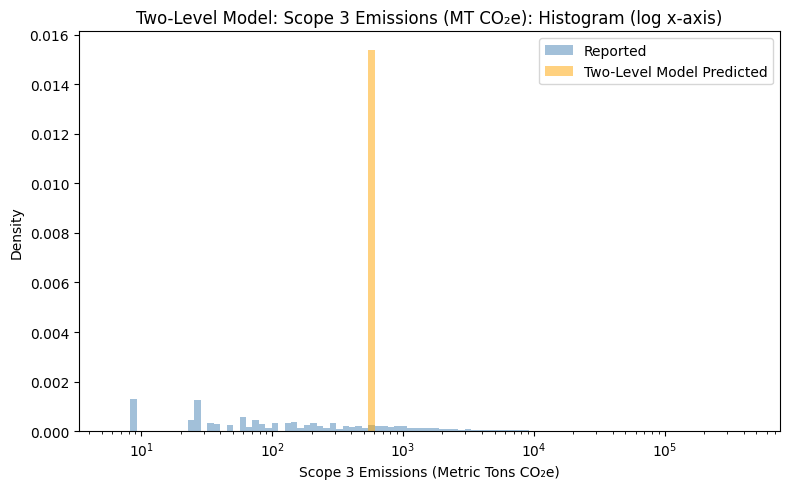

In [19]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- Check group sizes ---
group_sizes = train_df.groupby('account_id').size()
print("Two-Level Model: Company/year group size summary:")
print(group_sizes.describe())

# --- FIT THE TWO-LEVEL MODEL (random intercept, +Year, +Year_sq) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ Year + Year_sq",
        train_df,
        groups=train_df["account_id"],
        re_formula="1"
    )
    result_twolevel = model.fit(method="lbfgs")

if not result_twolevel.converged:
    print("WARNING: Two-level mixed model did not fully converge.")

print(result_twolevel.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_twolevel.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_mixed']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='orange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Two-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='orange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Two-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="orange", alpha=0.5, label="Two-Level Model Predicted")
plt.xscale("log")
plt.title("Two-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
two_level_model_metrics = {
    "Model": "2-level (RI+S)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "+Year, Year_sq"
}

## Business Travel Three-Level Mixed-Effects Model

A three-level hierarchical linear mixed-effects model is used to predict log-transformed Scope 3 emissions. It takes into account differences between primary activity, differences between companies, and changes over time. The model is trained using data from 2018 to 2022, and then tested on new data from 2023. This model provides insight on how emissions are influenced by primary activity, by individual companies, by financial and emissions factors, and by trends over time.

Model Structure:

- Level 3 (Primary Activity):<br>
    - Random intercept and random slope for Year for each primary activity ('Primary_activity'), capturing baseline primary activity and primary activity-specific time trends.<br>
- Level 2 (Account/Company):
    - Random intercept for each company ('account_id'), capturing company-level deviations within each primary activity.
- Level 1 (Yearly Observations):
    - Repeated annual observations within each company.

- Fixed Effects:
    - Signed log-transformed market cap ('slog_Market_Cap_USD')
    - Signed log-transformed revenue ('slog_Revenue_USD')
    - Signed log-transformed EBITDA ('slog_ebitda_USD')
    - Signed log-transformed Scope 1 & 2 emissions ('slog_scope_1_2_emissions_amount')

                     Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_Scope_3_emissions_amount
No. Observations:    4130     Method:              REML                        
No. Groups:          125      Scale:               0.7657                      
Min. group size:     1        Log-Likelihood:      -6440.8568                  
Max. group size:     361      Converged:           Yes                         
Mean group size:     33.0                                                      
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            -4.426    0.601 -7.362 0.000 -5.604 -3.248
slog_Market_Cap_USD                   0.406    0.027 15.118 0.000  0.353  0.458
slog_Revenue_USD                      0.029    0.008  3.613 0

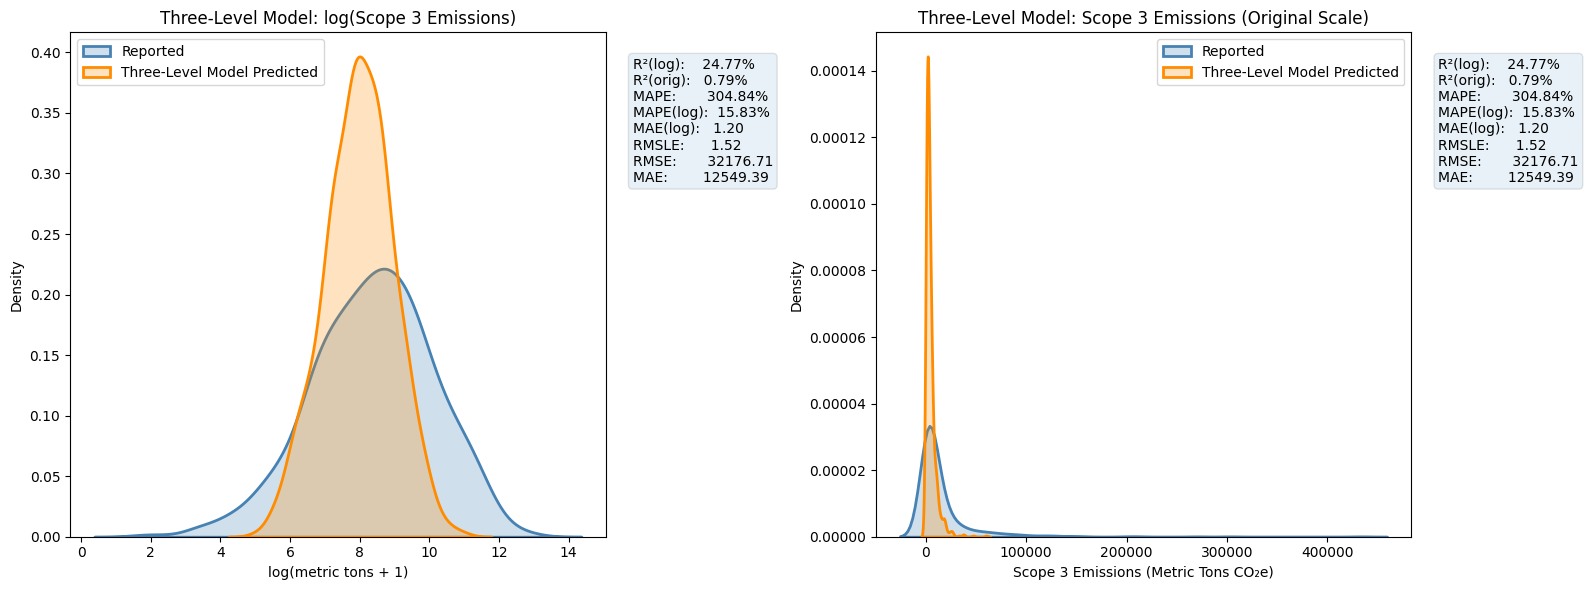

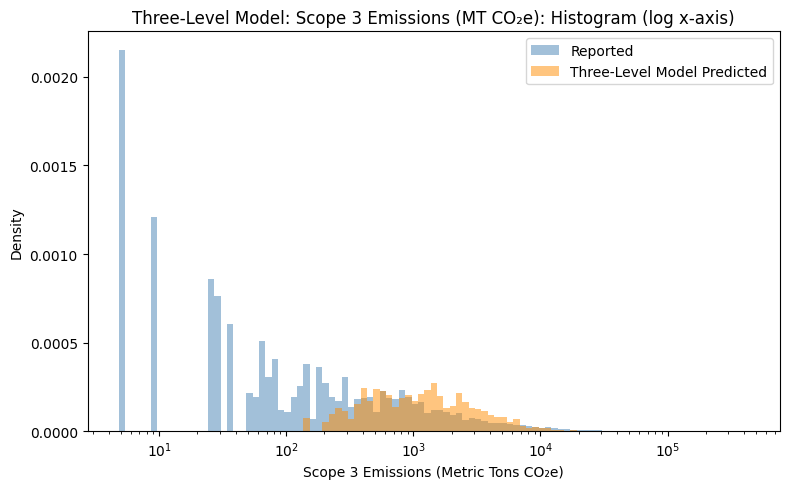

In [20]:
# --- Ensure grouping/categorical variables are string ---
for col in ['Countries', 'account_id', 'Primary_activity', 'Primary_sector']:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# --- Center the Year variable ---
year_mean = train_df['Year'].mean()
train_df['Year_centered'] = train_df['Year'] - year_mean
test_df['Year_centered'] = test_df['Year'] - year_mean

# --- Ensure log-transformed target exists ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE 3-LEVEL MIXED MODEL with Primary_activity as Level 3 group ---
vc = {'account_id': '0 + C(account_id)'}  # Level 2: account_id random intercept

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model_3level = MixedLM.from_formula(
        'log_Scope_3_emissions_amount ~ slog_Market_Cap_USD + slog_Revenue_USD + slog_ebitda_USD + slog_scope_1_2_emissions_amount',
        groups='Primary_activity',
        re_formula='~Year_centered',
        vc_formula=vc,
        data=train_df
    )
    result_3level = model_3level.fit(method="lbfgs", maxiter=1000)

if not result_3level.converged:
    print("WARNING: Three-level mixed model did not fully converge.")

print(result_3level.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_3level.predict(test_df)

# --- Compute back-transformed values ---
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])

# --- Robust Mask for finite values everywhere ---
mask = (
    np.isfinite(test_df['log_Scope_3_emissions_amount']) &
    np.isfinite(test_df['predicted_mixed']) &
    np.isfinite(test_df['Reported_Scope_3']) &
    np.isfinite(test_df['Predicted_Scope_3'])
)
test_df = test_df.loc[mask].copy()

y_true_log = test_df['log_Scope_3_emissions_amount'].values
y_pred_log = test_df['predicted_mixed'].values
y_true = test_df['Reported_Scope_3'].values
y_pred = test_df['Predicted_Scope_3'].values

# Final defensive check and diagnostics
arrays = {
    "y_true_log": y_true_log,
    "y_pred_log": y_pred_log,
    "y_true": y_true,
    "y_pred": y_pred,
}
for arr_name, arr in arrays.items():
    if not np.all(np.isfinite(arr)):
        print(f"ERROR: {arr_name} contains non-finite values!")
        print(f"Non-finite indices: {np.where(~np.isfinite(arr))[0]}")
        print(f"Values: {arr[~np.isfinite(arr)]}")
        raise ValueError(f"{arr_name} contains infs or NaNs after masking!")

# --- METRICS ---
mae_log = mean_absolute_error(y_true_log, y_pred_log)
nonzero_mask = y_true_log != 0
if np.any(nonzero_mask):
    mape_log = np.mean(np.abs((y_true_log[nonzero_mask] - y_pred_log[nonzero_mask]) / y_true_log[nonzero_mask])) * 100
else:
    mape_log = np.nan

r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)

metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if len(np.unique(y_pred_log)) > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Three-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

if len(np.unique(y_pred)) > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Three-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Filter strictly positive values for histogram (log x-axis requires >0)
y_true_pos = y_true[y_true > 0]
y_pred_pos = y_pred[y_pred > 0]

if y_true_pos.size > 0 and y_pred_pos.size > 0:
    min_val = min(y_true_pos.min(), y_pred_pos.min())
    max_val = max(y_true_pos.max(), y_pred_pos.max())
    if min_val == max_val:
        print("Skipping histogram: Only one unique positive value present.")
    else:
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

        plt.figure(figsize=(8, 5))
        sns.histplot(y_true_pos, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
        sns.histplot(y_pred_pos, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Three-Level Model Predicted")
        plt.xscale("log")
        plt.title("Three-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
        plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Skipping histogram: Not enough positive values in y_true or y_pred for log-scale histogram.")

# --- RETURN METRICS FOR SUMMARY TABLE ---
three_level_model_metrics = {
    "Model": "3-level (Primary Activity/Account/Year)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,
    "MAPE(log)": mape_log,
}

## Business Travel Full Mixed-Effects Model

A full mixed-effects model is used to predict company Scope 3 emissions, using financial and emissions data, along with information about country, industry, and year. The model is trained on data from 2018 to 2022, and tested on data from 2023. This full model helps provides insights into how a company’s finances, emissions, primary activity, country and the year influence emissions.<br>

Model Structure:<br>

- Random Effects:<br>
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:<br>
    - Signed log-transformed financial and emissions features:<br>
        - Market Cap ('slog_Market_Cap_USD')<br>
        - Revenue ('slog_Revenue_USD')<br>
        - EBITDA ('slog_ebitda_USD')<br>
        - Total Investments ('slog_ebitda_USD')<br>
        - Total Debt ('slog_totalDebt_USD')<br>
        - Gross Profit ('slog_grossProfit_USD')<br>
        - Net Income ('slog_netIncome_USD')<br>
        - Short-Term Investments ('slog_shortTermInvestments_USD')<br>
        - Total Assets ('slog_totalAssets_USD')<br>
        - Total Equity ('slog_totalEquity_USD')<br>
        - Scope 1&2 Emissions ('slog_scope_1_2_emissions_amount')<br>
    - Country ('Countries', as a categorical variable)<br>
    - Primary Activity ('Primary_activity', as a categorical variable)<br>
    - Year (numeric)<br>

                                         Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                slog_Scope_3_emissions_amount
No. Observations:                4130                   Method:                            ML                           
No. Groups:                      874                    Scale:                             0.8015                       
Min. group size:                 1                      Log-Likelihood:                    -6078.3064                   
Max. group size:                 5                      Converged:                         Yes                          
Mean group size:                 4.7                                                                                    
------------------------------------------------------------------------------------------------------------------------
                                                                          

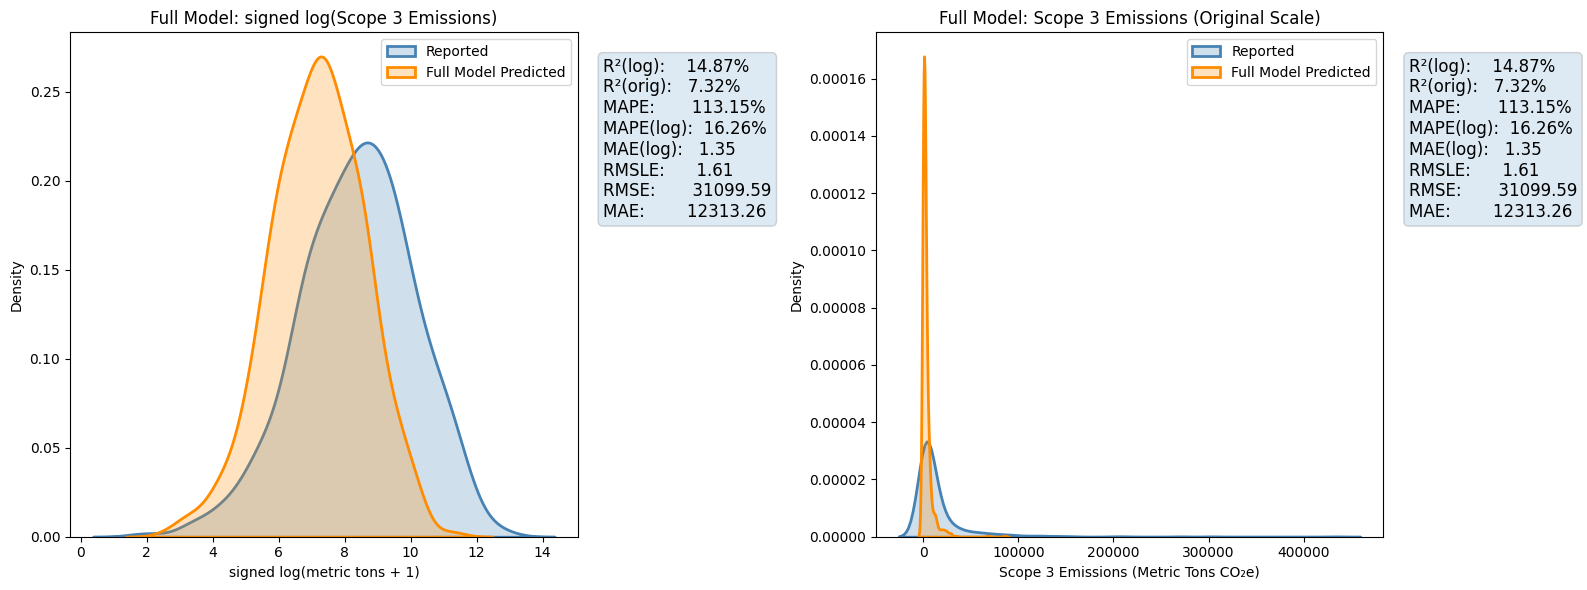

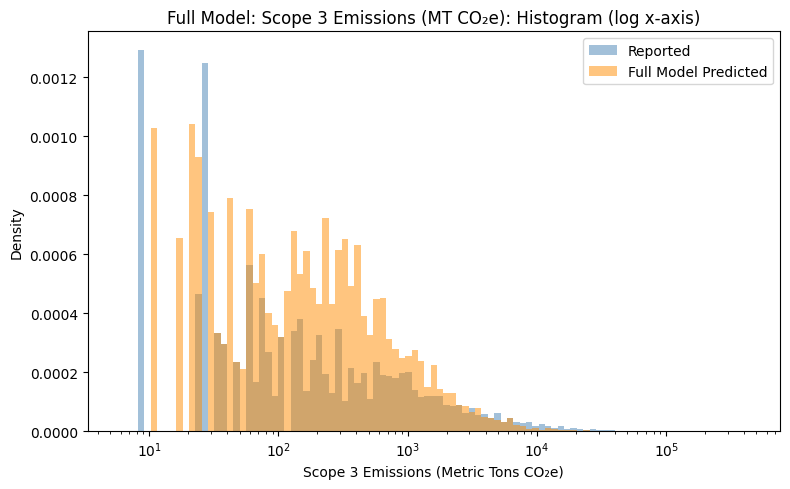

In [21]:
# --- Feature and target columns ---
numeric_cols = [
    'Market_Cap_USD', 'totalInvestments_USD', 'Revenue_USD', 'ebitda_USD', 'grossProfit_USD',
    'netIncome_USD', 'totalDebt_USD', 'shortTermInvestments_USD', 'totalAssets_USD',
    'totalEquity_USD', 'scope_1_2_emissions_amount', 'Scope_3_emissions_amount'
]
feature_cols_slog = [f'slog_{col}' for col in numeric_cols if col != 'Scope_3_emissions_amount']
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
required_cols = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_full = train_df.dropna(subset=required_cols).copy()
test_df_full = test_df.dropna(subset=required_cols).copy()

if test_df_full.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the full mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_full, groups=train_df_full['account_id'])
        mdf = md.fit(reml=False)
    print(mdf.summary())

    # --- Predict on test set ---
    test_df_full['predicted_log'] = mdf.predict(test_df_full)
    test_df_full['predicted'] = np.sign(test_df_full['predicted_log']) * (np.expm1(np.abs(test_df_full['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_full[target_col_slog]
    y_pred_log = test_df_full['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_full['predicted']

    # Mask for finite values
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nFull Mixed-Effects Model (Full Model) Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf.params,
        'pvalue': mdf.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Full Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Full Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Full Model Predicted")
    plt.xscale("log")
    plt.title("Full Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    full_model_metrics = {
        "Model": "Full Model",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

## Business Travel Optimized Mixed-Effects Model

An optimized mixed-effects model is used to predict company Scope 3 emissions. The model provides accurate prediction using only the most significant predictive features, while still accounting for primary activity, country and company level effects. The model is trained on data from 2018–2022 and evaluated on test data from 2023.

Model Structure:

- Random Effects:
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:
    - Signed log-transformed features:
        - Market Cap ('slog_Market_Cap_USD')
        - Revenue ('slog_Revenue_USD')
        - Total Debt ('slog_totalDebt_USD')
        - Total Assets ('slog_totalAssets_USD')
        - Total Equity ('slog_totalEquity_USD')
        - Scope 1 & 2 Emissions ('slog_scope_1_2_emissions_amount')
    - Country ('Countries', as a categorical variable)
    - Primary Activity ('Primary_activity', as a categorical variable)

                                       Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              slog_Scope_3_emissions_amount
No. Observations:                4130                 Method:                          ML                           
No. Groups:                      874                  Scale:                           1.1737                       
Min. group size:                 1                    Log-Likelihood:                  -6714.1832                   
Max. group size:                 5                    Converged:                       Yes                          
Mean group size:                 4.7                                                                                
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [

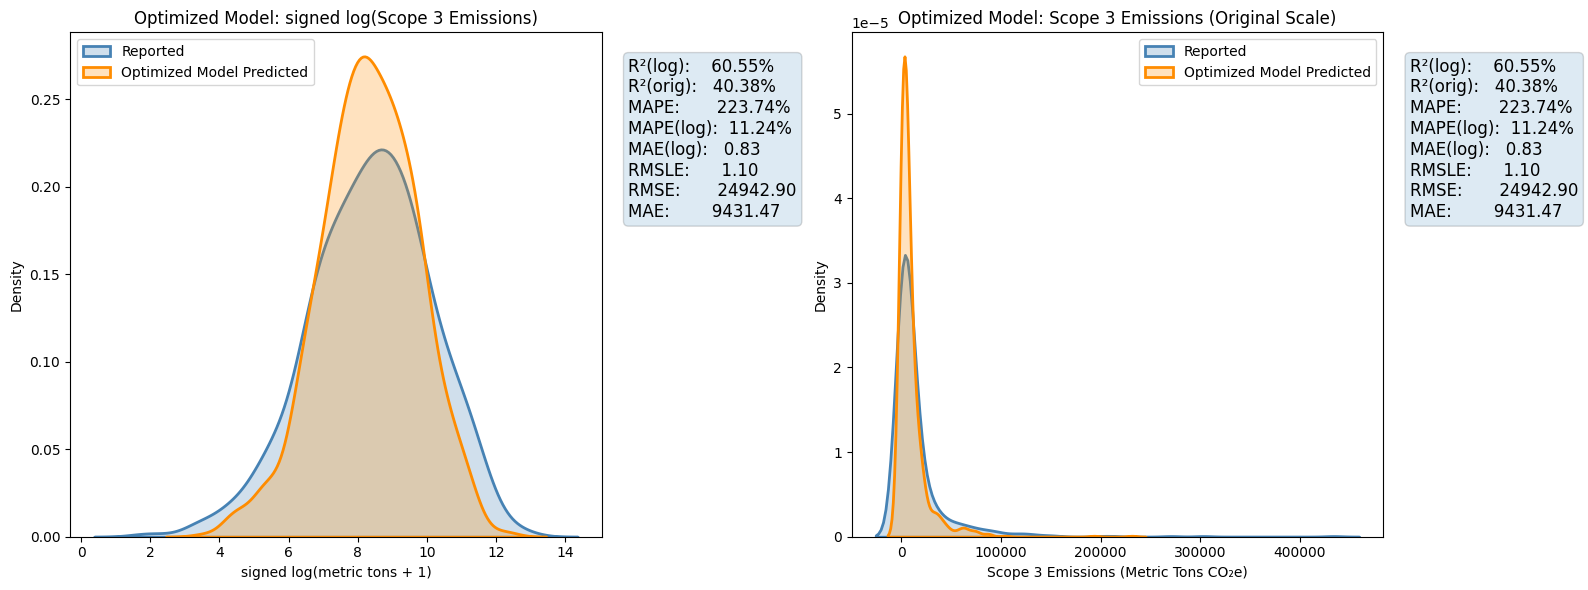

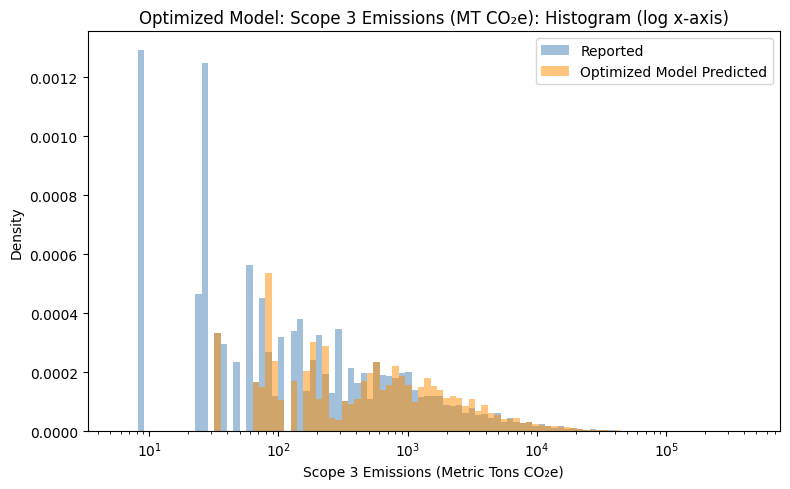

In [22]:
feature_cols_slog = [
    'slog_Market_Cap_USD',
    'slog_Revenue_USD',
    'slog_totalDebt_USD',
    'slog_totalAssets_USD',
    'slog_totalEquity_USD',
    'slog_scope_1_2_emissions_amount'
]
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
all_model_vars = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_opt = train_df.dropna(subset=all_model_vars).copy()
test_df_opt = test_df.dropna(subset=all_model_vars).copy()

if test_df_opt.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity)'
        # Year is excluded due to lack of significance in optimized model
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the optimized mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_opt, groups=train_df_opt['account_id'])
        mdf_optimized = md.fit(reml=False)
    print(mdf_optimized.summary())

    # --- Predict on test set ---
    test_df_opt['predicted_log'] = mdf_optimized.predict(test_df_opt)
    test_df_opt['predicted'] = np.sign(test_df_opt['predicted_log']) * (np.expm1(np.abs(test_df_opt['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_opt[target_col_slog]
    y_pred_log = test_df_opt['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_opt['predicted']

    # Mask for valid/finites
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <-- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nOptimized Mixed-Effects Model: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_optimized.params,
        'pvalue': mdf_optimized.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Optimized Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Optimized Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()
    

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Optimized Model Predicted")
    plt.xscale("log")
    plt.title("Optimized Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    optimized_model_metrics = {
        "Model": "Optimized",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

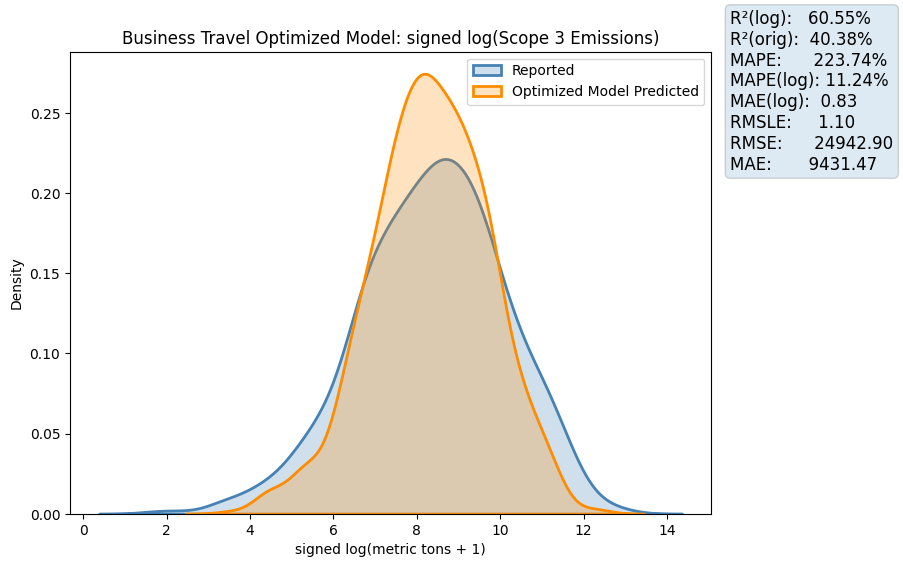

In [23]:
# --- Metrics box for plot: Show all metrics ---
metrics_text_log = (
    f"R²(log):   {r2_log_pct:.2f}%\n"
    f"R²(orig):  {r2_pct:.2f}%\n"
    f"MAPE:      {mape_orig:.2f}%\n"
    f"MAPE(log): {mape_log:.2f}%\n"
    f"MAE(log):  {mae_log:.2f}\n"
    f"RMSLE:     {rmsle:.2f}\n"
    f"RMSE:      {rmse_orig:.2f}\n"
    f"MAE:       {mae_orig:.2f}"
)

fig, ax = plt.subplots(figsize=(9.5, 6))  # Wider to make room for the box

if hasattr(y_pred_log, "nunique"):
    multiple_vals = y_pred_log.nunique() > 1
else:
    multiple_vals = len(set(y_pred_log)) > 1

if multiple_vals:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=ax, color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    ax.plot([], [], ' ', label="Predicted: constant value (no KDE)")

ax.set_title("Business Travel Optimized Model: signed log(Scope 3 Emissions)")
ax.set_xlabel("signed log(metric tons + 1)")
ax.set_ylabel("Density")
ax.legend()

# Place metrics box outside plot to the right
fig.text(
    0.82, 0.95, metrics_text_log,  # Higher up since box is taller
    va='top', ha='left',
    fontsize=12, bbox=dict(boxstyle='round', alpha=0.15)
)

plt.subplots_adjust(right=0.8)  # Make sure there's room for the box
fig.savefig("business_travel_scope3_log_density.png", dpi=300, bbox_inches='tight')
plt.show()

# Metrics Table for Business Travel

In [24]:
metrics_dicts = [
    null_model_metrics,
    two_level_model_metrics,
    three_level_model_metrics,
    full_model_metrics,
    optimized_model_metrics
]

for metrics, train, test in zip(
        metrics_dicts,
        [train_df, train_df, train_df, train_df, train_df],
        [test_df, test_df, test_df, test_df, test_df]):
    
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"

metrics_df = pd.DataFrame(metrics_dicts)

# Ensure all relevant columns are ordered and present
desired_order = [
    "Model", "R2_log", "R2_orig", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)"
]


# Ensure MAE_log is present, fill with NaN if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

metrics_df_display = metrics_df.copy()
if "R2_log" in metrics_df_display.columns:
    metrics_df_display["R2_log"] = (metrics_df_display["R2_log"] * 100).map("{:.2f}%".format)
if "R2_orig" in metrics_df_display.columns:
    metrics_df_display["R2_orig"] = (metrics_df_display["R2_orig"] * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "MAPE(log)"]:
    if col in metrics_df_display.columns:
        metrics_df_display[col] = metrics_df_display[col].map("{:.2f}".format)

from IPython.display import display
display(metrics_df_display)

,Model,R2_log,R2_orig,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test)
0,Null (RI),-0.34%,-12.66%,34287.36,13701.74,1.40,1.75,560.15,4130/789
1,2-level (RI+S),-131.58%,-20.89%,35518.66,14838.34,2.26,2.66,130.27,4130/789
2,3-level (Primary Activity/Account/Year),24.77%,0.79%,32176.71,12549.39,1.20,1.52,304.84,4130/789
3,Full Model,14.87%,7.32%,31099.59,12313.26,1.35,1.61,113.15,4130/789
4,Optimized,60.55%,40.38%,24942.90,9431.47,0.83,1.10,223.74,4130/789
